In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd

import numpy as np

import os, sys

from utils import spectrogram

In [2]:
VCB_PATH = "/home/ubuntu/data/voxceleb1_wav"
names = [d for d in os.listdir(VCB_PATH) if os.path.isdir(os.path.join(VCB_PATH, d))]

audio_clips = {}
for name in names:
    audio_clips[name] = os.listdir(VCB_PATH + '/' + name)

names = sorted(names, key=lambda name : -len(audio_clips[name]))
print(names[:10])
ipd.Audio('/'.join([VCB_PATH, names[0], audio_clips[names[0]][0]]))

['Rob_Reiner', 'Bob_Barker', 'Alan_Alda', 'Stephen_Fry', 'Louis_C.K.', 'Peter_Jackson', 'Vince_Gilligan', 'J.J._Abrams', 'Quentin_Tarantino', 'David_Attenborough']


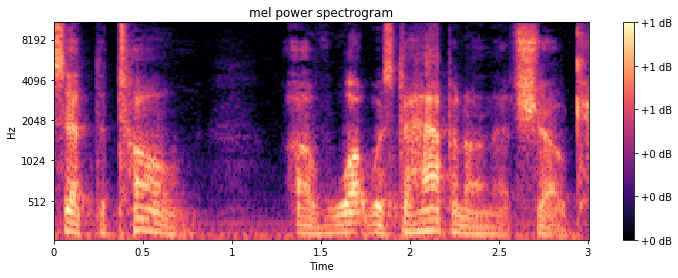

In [3]:
spectrogram.show_rand_spectrogram_crop('/'.join([VCB_PATH, names[0], audio_clips[names[0]][0]]), 3)

In [4]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

torch.manual_seed(42)
np.random.seed(6 * 9)

In [18]:
class EmbeddingDataset(data_utils.Dataset):
    
    def __init__(self, vcb_root, embed_split_txt_path, crop_length=3):
        """
        crop_length is the length in seconds to which to the training example is randonmly cropped
        """
        self.vcb_root = vcb_root
        self.crop_length = crop_length
        with open(embed_split_txt_path) as f:
            self.paths = [line.rstrip().split(" ") for line in f.readlines()]
            for i in range(len(self.paths)):
                self.paths[i][0] = float(self.paths[i][0])
        
        self.num_inputs = 2
        self.num_targets = 1

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        y, wav1, wav2 = self.paths[idx]
        wavs = (wav1, wav2)
        
        specs = []
        for wav in wavs:
            spec = spectrogram.get_rand_spectrogram_crop(os.path.join(self.vcb_root, wav),
                                                         self.crop_length).T
            specs += [spec]
        
        return {
            "y": y,
            "sp1": specs[0],
            "sp2": specs[1]
        }

In [19]:
import collections
import re

def custom_collate(batch):
    """
    From http://pytorch.org/docs/master/_modules/torch/utils/data/dataset.html#Dataset
    """
    
    error_msg = "batch must contain tensors, numbers, dicts or lists; found {}"
    elem_type = type(batch[0])
    if torch.is_tensor(batch[0]):
        out = None
        if _use_shared_memory:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = batch[0].storage()._new_shared(numel)
            out = batch[0].new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        elem = batch[0]
        if elem_type.__name__ == 'ndarray':
            # array of string classes and object
            if re.search('[SaUO]', elem.dtype.str) is not None:
                raise TypeError(error_msg.format(elem.dtype))

            return torch.stack([torch.from_numpy(b) for b in batch], 0).type(torch.FloatTensor)
    elif isinstance(batch[0], int):
        return torch.LongTensor(batch)
    elif isinstance(batch[0], float):
        return torch.FloatTensor(batch)
    elif isinstance(batch[0], collections.Mapping):
        ret_dict = {key: custom_collate([d[key] for d in batch]) for key in batch[0]}
        return [ret_dict['sp1'], ret_dict['sp2']], ret_dict['y'] 
    elif isinstance(batch[0], collections.Sequence):
        transposed = zip(*batch)
        return [default_collate(samples) for samples in transposed]

    raise TypeError((error_msg.format(type(batch[0]))))

train_dataset = EmbeddingDataset("/home/ubuntu/data/voxceleb1_wav", "/home/ubuntu/data/embed-split.txt")
train_loader = data_utils.DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)
for i, batch in enumerate(train_loader):
    print(batch[0][0].type())
    print(batch[1].type())
    print(len(batch))
    break

torch.FloatTensor
torch.FloatTensor
2


In [20]:
class SiameseLSTMVoice(nn.Module):

    def __init__(self, input_dim, hidden_dim, depth, batch_size, output_dim):
        super(SiameseLSTMVoice, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.depth = depth
        self.batch_size = batch_size
        self.output_dim = output_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, depth, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward_once(self, batch):
        lstm_out, _ = self.lstm(batch)
        lstm_out_mean = torch.mean(lstm_out, 1)
        output = self.fc(lstm_out_mean)
        return output
        
    def forward(self, batch1, batch2):
        output1 = self.forward_once(batch1)
        output2 = self.forward_once(batch2)
        return output1, output2

In [21]:
def ContrastiveLoss(outputs, label):
    euclidean_distance = nn.functional.pairwise_distance(outputs[0], outputs[1])
    loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(1 - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [22]:
INPUT_DIM = 128
HIDDEN_DIM = 256
DEPTH = 1
BATCH_SIZE = 64
OUTPUT_DIM = 256

model = SiameseLSTMVoice(INPUT_DIM, HIDDEN_DIM, DEPTH, BATCH_SIZE, OUTPUT_DIM)
model.cuda()

SiameseLSTMVoice (
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear (256 -> 256)
)

In [25]:
from torchsample.modules import ModuleTrainer
from torchsample.callbacks import ModelCheckpoint
from torchsample.initializers import XavierUniform

trainer = ModuleTrainer(model)

callbacks = [ModelCheckpoint("/home/ubuntu/models", filename="embed-test-{epoch}-{loss}")]
regularizers = None
constraints = None
initializers = [XavierUniform(bias=False, module_filter='fc*')]
metrics=None

trainer.compile(loss=ContrastiveLoss,
                optimizer='rmsprop',
                callbacks=callbacks,
                regularizers=regularizers,
                constraints=constraints,
                initializers=initializers,
                metrics=metrics)

train_dataset = EmbeddingDataset("/home/ubuntu/data/voxceleb1_wav", "/home/ubuntu/data/embed-split.txt")
train_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                     shuffle=True, collate_fn=custom_collate,
                                     num_workers=3)

In [ ]:
torch.manual_seed(42)
np.random.seed(6 * 9)
trainer.fit_loader(train_loader, num_epoch=3, cuda_device=0)

Epoch 1/3:   8%|▊         | 49/590 [01:42<15:46,  1.75s/ batches, loss=2.3647] 